In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import torch

from juart.conopt.functional.fourier import fourier_transform_adjoint
from juart.recon.ncgrappa import NonCartGrappa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
spiral_dset = h5py.File("recon.h5", "r")
print(spiral_dset.keys())
print(spiral_dset["acs"].keys())

fov = spiral_dset.attrs["fov"]
matrix = spiral_dset.attrs["matrix"]

<KeysViewHDF5 ['acs', 'image']>
<KeysViewHDF5 ['data_comp', 'sens_maps']>


In [152]:
ksp_spiral = torch.from_numpy(spiral_dset["image/data"][:])
ktraj_spiral = torch.from_numpy(spiral_dset["image/ktraj"][:])

# Bring to Juart format
ktraj_spiral[0] = ktraj_spiral[0] * fov[0] / matrix[0]
ktraj_spiral[1] = ktraj_spiral[1] * fov[1] / matrix[1]

print("Shape of ksp_spiral:", ksp_spiral.shape)
print("Shape of ktraj_spiral:", ktraj_spiral.shape)

num_dim, num_col, num_slc, num_eco = ktraj_spiral.shape
num_cha, *_ = ksp_spiral.shape

Shape of ksp_spiral: torch.Size([12, 3090, 30, 2])
Shape of ktraj_spiral: torch.Size([2, 3090, 30, 2])


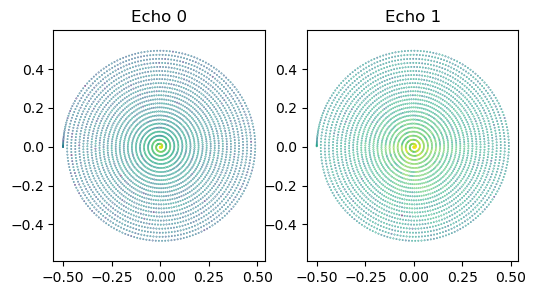

In [153]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(6, 3),
)
axes[0].set_title("Echo 0")
axes[0].scatter(
    ktraj_spiral[0, :, num_slc // 2, 0],
    ktraj_spiral[1, :, num_slc // 2, 0],
    s=0.1,
    c=torch.abs(ksp_spiral[0, :, num_slc // 2, 0]),
    norm="log",
)

axes[1].set_title("Echo 1")
axes[1].scatter(
    ktraj_spiral[0, :, num_slc // 2, 1],
    ktraj_spiral[1, :, num_slc // 2, 1],
    s=0.1,
    c=torch.abs(ksp_spiral[0, :, num_slc // 2, 1]),
    norm="log",
)

for ax in axes:
    ax.axis("equal")

In [154]:
ksp_acs = torch.from_numpy(spiral_dset["acs/data_comp"][:])
coil_sens = torch.from_numpy(spiral_dset["acs/sens_maps"][:])

# Bring to Juart format
ksp_acs = ksp_acs.moveaxis(3, 0)  # Move coil dimension to the front
coil_sens = coil_sens.moveaxis(3, 0)  # Move coil dimension to the front

print("Shape of ksp_acs:", ksp_acs.shape)
print("Shape of coil_sens:", coil_sens.shape)

Shape of ksp_acs: torch.Size([12, 96, 96, 1, 30])
Shape of coil_sens: torch.Size([12, 96, 96, 1, 30])


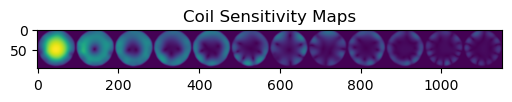

In [155]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

ax.set_title("Coil Sensitivity Maps")
ax.imshow(
    torch.abs(coil_sens[..., 0, num_slc // 2].reshape(-1, coil_sens.shape[2]).T),
)

# Non-Cartesian GRAPPA reconstruction

In [ ]:
# Reconstruct to a cartesian grid

xs = torch.linspace(-0.5, 0.5, steps=matrix[0])
ys = torch.linspace(-0.5, 0.5, steps=matrix[1])
x, y = torch.meshgrid(xs, ys, indexing="xy")

grid = torch.stack([x, y], dim=0)

grid_ravel = grid.reshape(2, -1, 1, 1).repeat(1, 1, num_slc, num_eco)

grid_samples = torch.zeros(
    (num_cha, *grid_ravel.shape[1:]), dtype=torch.complex64, device=ksp_spiral.device
)

# Combine ksp and ktraj of spiral and cartesian data

# Append sampling mask
grid_ravel = torch.cat(
    [grid_ravel, torch.zeros(1, *grid_ravel.shape[1:], device=grid_ravel.device)],
    dim=0,
)

ktraj_comb = torch.cat(
    [ktraj_spiral, torch.ones(1, *ktraj_spiral.shape[1:], device=ktraj_spiral.device)],
    dim=0,
)

# Combine ktraj
ktraj_comb = torch.cat([ktraj_comb, grid_ravel], dim=1)

# Combine ksp
ksp_comb = torch.cat([ksp_spiral, grid_samples], dim=1)

In [157]:
# Cut off zero filled ksp of acs region
from juart.utils import resize

ksp_acs = resize(ksp_acs, size=(30, 30), dims=(1, 2))

In [158]:
# Calculate weights for ncgrappa
ncgrappa = NonCartGrappa(
    ktraj=ktraj_comb[:, :, num_slc // 2, 0],
    calib_signal=ksp_acs[..., 0, num_slc // 2],
    img_size=matrix[0:2],
    kernel_size=(9, 9),
    tik=1e-3,
    shift_tol=1e-6,
    verbose=5,
)

Scaled kspace trajectory to [cycle/fov] units.
Maximum k-space coordinates [x, y]: tensor([48., 48.])
Minimum k-space coordinates [x, y]: tensor([-48.0490, -48.0000])

Number of total locations in k-space: 12306
Number of sampled locations in k-space: 3090
Number of unsampled locations in k-space: 9216 

------------------------------------------------
Perform KDTree search of patch constellations.
Neighbor search distance: ±[4.5, 4.5]
Sampled points shape: torch.Size([2, 3090])
Unsampled points shape: torch.Size([2, 9216])
Found 9216 patches.
KDTree search completed in 18.204 ms. 



Number of patches: 9216
[#Neigbors, Num Patches] [[0, 1105], [1, 116], [2, 119], [3, 96], [4, 58], [5, 78], [6, 67], [7, 72], [8, 61], [9, 79], [10, 73], [11, 88], [12, 96], [13, 79], [14, 64], [15, 83], [16, 89], [17, 87], [18, 111], [19, 74], [20, 72], [21, 83], [22, 98], [23, 94], [24, 129], [25, 156], [26, 239], [27, 419], [28, 552], [29, 585], [30, 529], [31, 413], [32, 367], [33, 348], [34, 270], [35, 271], [36, 293], [37, 269], [38, 276], [39, 229], [40, 224], [41, 175], [42, 130], [43, 87], [44, 98], [45, 50], [46, 34], [47, 17], [48, 5], [49, 7], [51, 2]]
Number of unique patch groups: 8111 



Calibrating patch groups: 100%|██████████| 8111/8111 [01:03<00:00, 127.95it/s]


In [159]:
# Apply ncgrappa weights

ksp_filled = ncgrappa.apply(ksp=ksp_comb[:, :, num_slc // 2, 0])

Applying GRAPPA weights: 100%|██████████| 8111/8111 [00:05<00:00, 1469.93it/s]


In [160]:
# Take only cartesian data from filled ksp

sample_mask = ktraj_comb[-1, :, num_slc // 2, 0] == 1
ksp_filled_cart = ksp_filled[:, ~sample_mask]

ksp_filled_cart = ksp_filled_cart.reshape(num_cha, matrix[0], matrix[1])

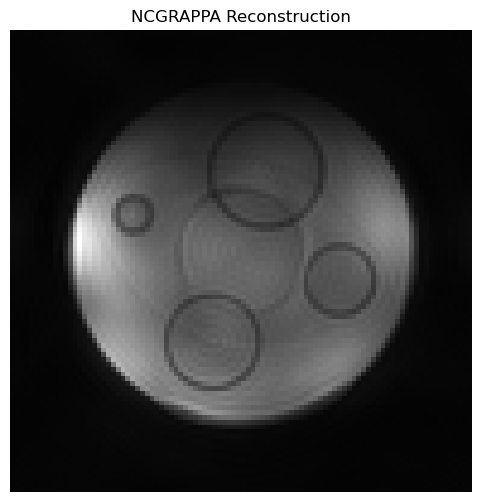

In [161]:
img_ncgrappa = fourier_transform_adjoint(x=ksp_filled_cart, axes=(1, 2))

img_ncgrappa_rss = torch.sqrt(torch.sum(torch.abs(img_ncgrappa) ** 2, dim=0))

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("NCGRAPPA Reconstruction")
ax.imshow(
    img_ncgrappa_rss.cpu().numpy(),
    cmap="gray",
    vmin=0,
    vmax=img_ncgrappa_rss.max().item(),
)
ax.axis("off")

plt.show()

# NUFFT Reconstruction

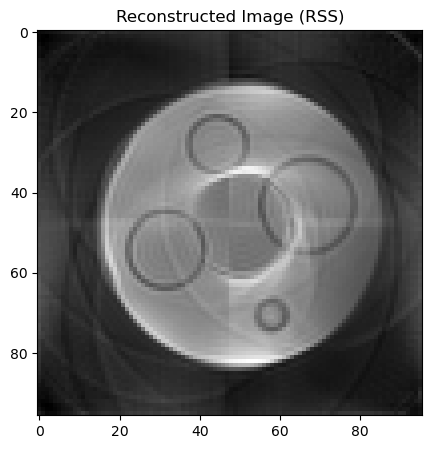

In [162]:
from juart.recon.cgnufft import cgnufft

img = cgnufft(
    ksp=ksp_spiral[:, :, num_slc // 2, 0],
    ktraj=ktraj_spiral[:, :, num_slc // 2, 0],
    img_size=(matrix[0], matrix[1]),
    maxiter=10,
)

img_rss = torch.sqrt(torch.sum(torch.abs(img) ** 2, dim=0))

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

ax.set_title("Reconstructed Image (RSS)")
ax.imshow(
    img_rss.numpy(),
    cmap="gray",
)

plt.show()

# SENSE Reconstruction

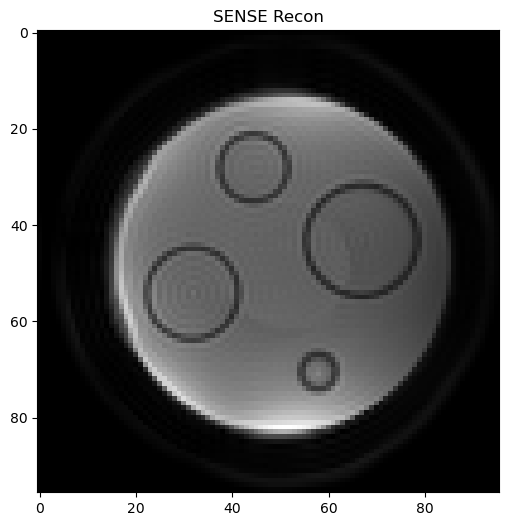

In [163]:
from juart.recon.sense import cgsense

coil_sens_flip = coil_sens.clone()
coil_sens_flip = coil_sens_flip.flip(1)
coil_sens_flip = coil_sens_flip.flip(2)
# coil_sens_flip = coil_sens_flip.moveaxis(1, 2)

img = cgsense(
    ksp_data=ksp_spiral[:, :, num_slc // 2, 0].contiguous(),
    ktraj=ktraj_spiral[:, :, num_slc // 2, 0].contiguous(),
    coil_sensitivities=coil_sens_flip[..., num_slc // 2].contiguous(),
    maxiter=15,
)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("SENSE Recon")
ax.imshow(
    torch.abs(img[0, ..., 0]),
    cmap="gray",
)